# Introduction (Original Text When I Made Notebook)

In this notebook I compare the linear and FULL nonlinear mesh PDE's (no linearization via M) when both problems are supplied the 1D HR Hessian Mesh Density Function which is computed based on an exact ufl expression for $u.$ Ideally, these mesh PDE's should produce the same $x(\xi)$ meshes (because they are equivalent problems).

I also then use the results of the above test to fuel a manual MP-Iteration and the FieldSplit automatic MP-Iteration and compare the results. I HAVE NOW ADDED AN HESSIAA SOLVE TO SMOOTH M

##### June 2025



# Introduction (August 2025)

There is alot going on in this notebook and I am having trouble parsing it later on. I think some of the key take-aways from this notebook are the individual pieces of code that can be pulled and used in other notebooks. Some of these include


- Bakhvalov Mesh Construction

- Analytic and numerical alpha_tilde solves for the HR Mesh Density Function (5.192)

- Chain ruled analytical Hessian calculation of firedrake ufl expression

- Linear HR Mesh solve based on the analytical Hessian

- Nonlinear HR Mesh solve based on the analytical Hessian

- Comparing Linear and Nonlinear Mesh Solves

- Doing a Physical Solve in CG4 on the resulting mesh.

- Computing L2 and Energy norm errors of the Physical Solution

- Hessian Recovery Solve to smooth M.

- Manual MP-Iteration with alpha solves

- Comparing MP-Ieration to Fieldsplit code (with alpha solves)


In [ ]:
# install firedrake

# hide output
%%capture

# try:
#     import firedrake
# except ImportError:
#     !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
#     import firedrake


try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [ ]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [ ]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
import sympy as sp
import scipy as sci

# Setup and Exact u

In [ ]:
# SETUP
#################################################

# Grid size and epsilon
N = 50
epsilon = Constant(0.01)


# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'basic',
        'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        # 'mat_type': 'nest'
        'pc_type' : 'lu'
}




# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
exp_M = (2*q) / (1 + q*(2-m))



# Initialize uniform mesh for xi
xi_mesh = UnitIntervalMesh(N)
xi_coord = SpatialCoordinate(xi_mesh)[0]


# Our function spaces
V = FunctionSpace(xi_mesh, "CG", 2)
V_alpha = FunctionSpace(xi_mesh, "R", 0)

# Set initial x(xi) to be uniform grid
x_old = Function(V)
x_old.interpolate(xi_coord)


# permute x_old to order coordinates
perm_old = np.argsort(x_old.dat.data[:])


# Set exact solution
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u = top/bottom - sub



# Create a B Mesh for Comparison

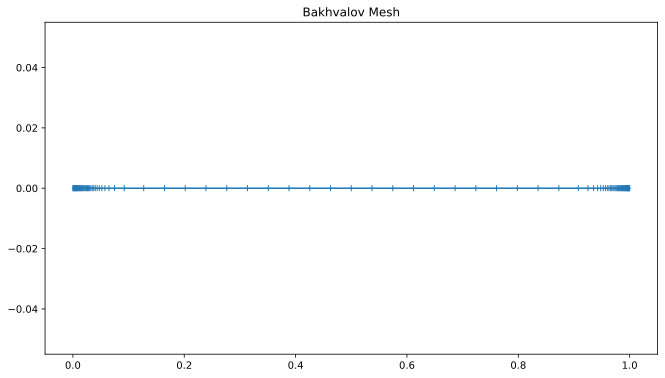

In [ ]:
# Form the 1D B mesh to compare

epsilon = 0.01
NB = 2*N
q = 0.4 #roughly 20 points in the layers
sigma = 2.5
b = 1
a = sigma/b
tau = q-a*epsilon
error = 1


while error>1e-14:

  g2 = a*epsilon*(0.5-tau)-(0.5+a*epsilon*np.log(1-tau/q))*(q-tau)
  g2_tau = 1 + a*epsilon*np.log(1-tau/q)
  tau_new =tau-g2/g2_tau
  error = abs(tau-tau_new)
  tau=tau_new


if tau>0:

  phi = -a*epsilon*np.log(1-tau/q)
  phi_tau = a*epsilon/(q-tau)
  x_uni = np.linspace(0, 1, NB+1)
  x_b = np.zeros(NB+1)

  for i in range(1,int(NB/2+1)):
    if x_uni[i]<tau:
      x_b[i] = -a*epsilon*np.log(1-x_uni[i]/q)
    else:
      x_b[i] = -a*epsilon*np.log(1-tau/q)+(x_uni[i]-tau)*phi_tau

  for i in range(int(NB/2+1),NB+1):
    x_b[i] = 1-x_b[NB-i]


else:

  x_b = np.linspace(0, 1, NB+1)


# Plot the result
plt.plot(x_b, [0 for i in range(NB+1)], marker = "|")
plt.title('Bakhvalov Mesh')
plt.show()




# Finding Alpha

## Alpha Tilda

In [ ]:
# FIND AN INITIAL ALPHA TILDA
#####################################################

# Find second derivative of u w.r.t x (symbolically)
xs, alpha_t = sp.symbols('xs, alpha_t')
eps = 0.01

# Define exact u symbolically
top = (1 - sp.exp(1 - 1/eps)) * sp.exp(-xs/eps) + (sp.exp(1) - sp.exp(-1/eps)) * sp.exp((xs - 1)/eps)
bottom = (eps**2 - 1) * (1 - sp.exp(-2/eps))
sub = sp.exp(xs) / (eps**2 - 1)
u_s = top / bottom - sub

# Take second derivative
du2_dx2 = sp.diff(u_s, xs, 2)

# Construct rho(x, alpha)
qs = 2
ms = 0
exp_rho_symp = (qs) / (1 + qs*(2-ms))
inside_bit = 1 + (1/alpha_t) * sp.Abs(du2_dx2)
rho = inside_bit ** (exp_rho_symp)

# Lambidfy rho
rho_func = sp.lambdify((xs, alpha_t), rho)


# Set up integral(rho) - 2 = 0
def alpha_tilda_problem(alpha_t):
  def integrand(xs_val):
    return rho_func(xs_val, alpha_t)
  int_val, _ = sci.integrate.quad(integrand, 0, 1)
  return int_val - 2


# Solve for alpha using fsolve
alpha_tilda = sci.optimize.fsolve(alpha_tilda_problem, 1)[0]
print('Our alpha_tilda is: ', alpha_tilda)

Our alpha_tilda is:  7.250865204319422


## Alpha

In [ ]:
# NOW FIND ALPHA
###########################################


# a_hat = 1.0

L2_u = sp.sqrt(sp.integrate(u_s**2, (xs, 0, 1)))

L2_u_val = L2_u.evalf()


# Compute alpha = max( a_hat * L2_u , alpha_tilda )

alpha = max(L2_u_val, alpha_tilda)


print('Our alpha is: ', alpha)

Our alpha is:  7.250865204319422


# Compute the Hessian

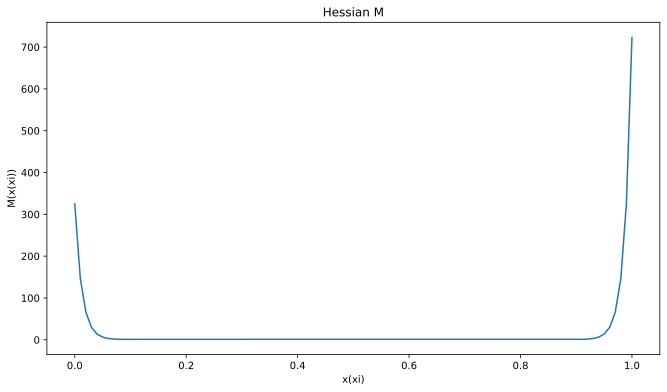

In [ ]:
# x_old jacobian
jacobx = x_old.dx(0)

# compute the derivatives of our u
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)

# compute the Hessian M using computed alpha tilda

# Compute alpha using alpha tilda
# alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
# alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
# M_lin = inside_bit_lin ** (exp_M)

M_lin = Function(V).interpolate(inside_bit_lin ** (exp_M))

# Lets plot this hessian
# plt.plot(x_old.dat.data[perm_old], Function(V).interpolate(M_lin).dat.data[perm_old])
plt.plot(x_old.dat.data[perm_old], M_lin.dat.data[perm_old])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

# Linear Mesh Solve

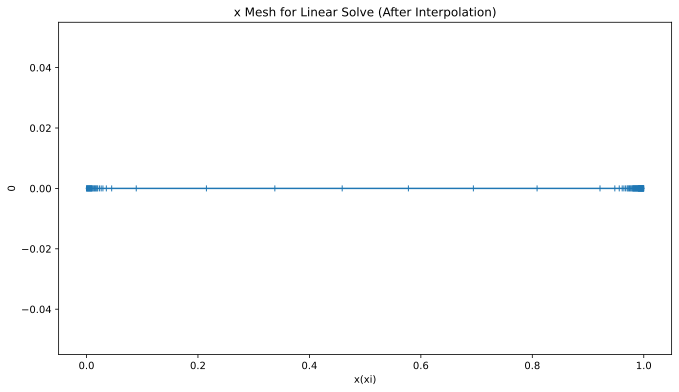

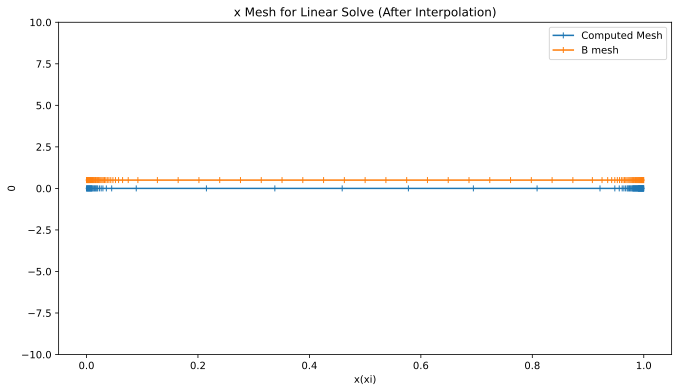

In [ ]:
# LINEAR Mesh Solve

# set solution and test function
new_xi = TrialFunction(V)
vm = TestFunction(V)

# jacobian
dxi_dx = new_xi.dx(0)

# v'
v_pr = (vm).dx(0)


# the problem
a = ( v_pr * (1/M_lin) * dxi_dx ) * dx
# a = ( v_pr * M_lin * (1/dxi_dx)) * dx
L = (Function(V) * vm ) * dx

# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]

# solve
new_xi = Function(V)
solve( a == L, new_xi, bcs = bcs)


# Inverse Interpolation to get x
perm_xi = np.argsort(new_xi.dat.data[:])
uni_array = x_old.dat.data[perm_xi]
xi_array = new_xi.dat.data[perm_xi]
x_xi = interp1d(xi_array, uni_array, kind='linear')
x_xi_array = x_xi(uni_array)


# Plot

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|")
plt.title('x Mesh for Linear Solve (After Interpolation)')
plt.xlabel("x(xi)")
plt.ylabel("0")
plt.show()
print()
print()

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Computed Mesh")
plt.plot(x_b, [1/2 for i in range(len(x_b))], marker = "|", label = "B mesh")
plt.title('x Mesh for Linear Solve (After Interpolation)')
plt.xlabel("x(xi)")
plt.ylabel("0")
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()


In [ ]:
print(x_xi_array)

[0.00000000e+00 6.35948203e-04 1.27189641e-03 1.90784461e-03
 2.54379281e-03 3.17974102e-03 3.81568922e-03 4.45163742e-03
 5.08758562e-03 5.72353383e-03 6.35948203e-03 6.99543023e-03
 7.63137844e-03 8.26732664e-03 8.90327484e-03 9.53922305e-03
 1.03798297e-02 1.17587775e-02 1.31377254e-02 1.45166732e-02
 1.58956210e-02 1.72745688e-02 1.86535167e-02 2.00737557e-02
 2.32065728e-02 2.63393899e-02 2.94722070e-02 3.56049160e-02
 4.51937884e-02 8.92907435e-02 2.15203332e-01 3.37986266e-01
 4.58844683e-01 5.77643942e-01 6.94256414e-01 8.08562861e-01
 9.21469952e-01 9.48064955e-01 9.56019808e-01 9.61302906e-01
 9.64365308e-01 9.67427711e-01 9.70226318e-01 9.71640434e-01
 9.73054549e-01 9.74468664e-01 9.75882780e-01 9.77296895e-01
 9.78711010e-01 9.80054908e-01 9.80675456e-01 9.81296004e-01
 9.81916552e-01 9.82537100e-01 9.83157648e-01 9.83778196e-01
 9.84398744e-01 9.85019292e-01 9.85639840e-01 9.86260388e-01
 9.86880936e-01 9.87501484e-01 9.88122032e-01 9.88742580e-01
 9.89363128e-01 9.899836

# Nonlinear Mesh Solve

  0 SNES Function norm 2.738261651058e+01
  1 SNES Function norm 1.348162700276e+01
  2 SNES Function norm 6.691362534462e+00
  3 SNES Function norm 3.333574548675e+00
  4 SNES Function norm 1.663767675968e+00
  5 SNES Function norm 8.311222405935e-01
  6 SNES Function norm 4.153675307639e-01
  7 SNES Function norm 2.076343613326e-01
  8 SNES Function norm 1.038046565210e-01
  9 SNES Function norm 5.189927649367e-02
 10 SNES Function norm 2.594899853703e-02
 11 SNES Function norm 1.297444377121e-02
 12 SNES Function norm 6.487282390702e-03
 13 SNES Function norm 3.243705050876e-03
 14 SNES Function norm 1.621898866145e-03
 15 SNES Function norm 8.109793409055e-04
 16 SNES Function norm 4.055079492021e-04
 17 SNES Function norm 2.027647894657e-04
 18 SNES Function norm 1.013886602860e-04
 19 SNES Function norm 5.069790377311e-05


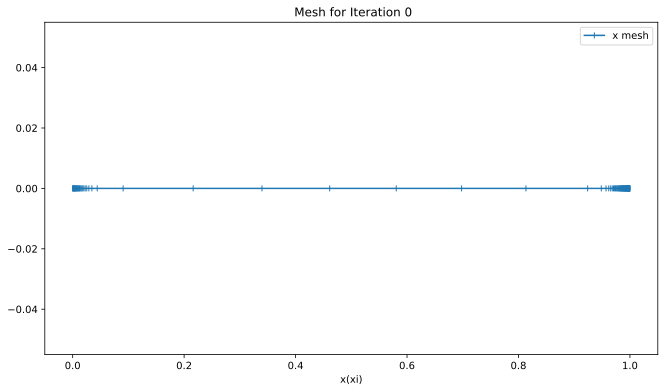



  0 SNES Function norm 5.069790377311e-05
  1 SNES Function norm 2.535096618560e-05


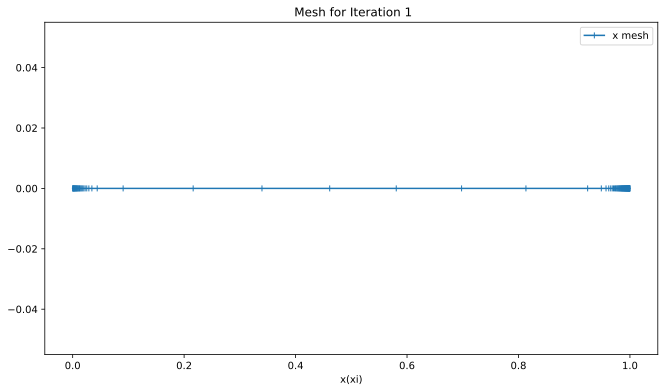



  0 SNES Function norm 2.535096618560e-05
  1 SNES Function norm 1.267661118548e-05


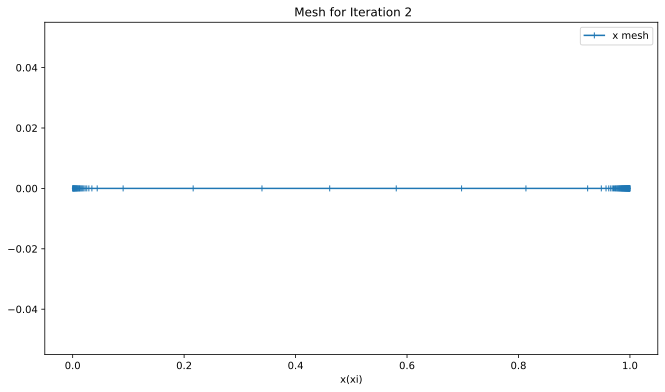



  0 SNES Function norm 1.267661118548e-05
  1 SNES Function norm 6.338931793418e-06


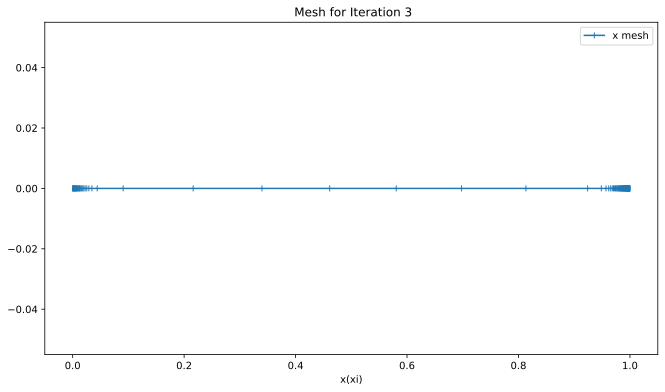



  0 SNES Function norm 6.338931793418e-06
  1 SNES Function norm 3.169808299668e-06


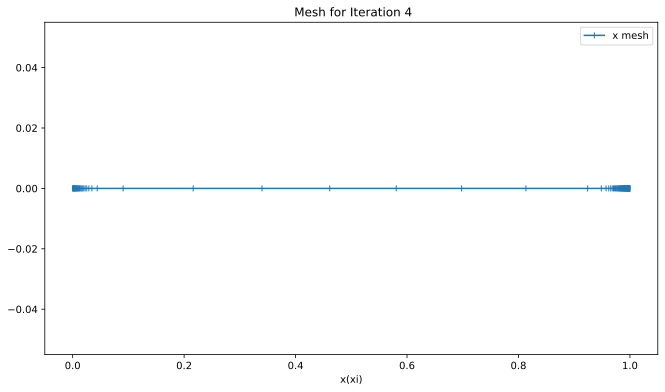



  0 SNES Function norm 3.169808299668e-06
  1 SNES Function norm 1.585090944530e-06


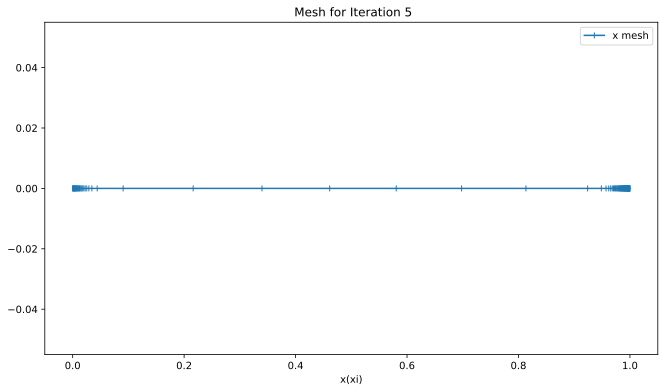



  0 SNES Function norm 1.585090944530e-06
  1 SNES Function norm 7.926437656453e-07


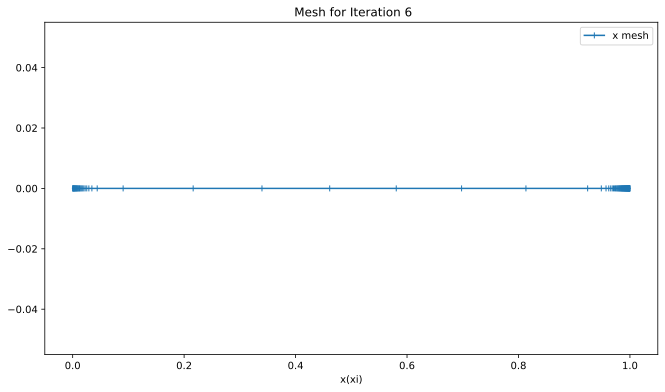



  0 SNES Function norm 7.926437656453e-07
  1 SNES Function norm 3.963778649787e-07


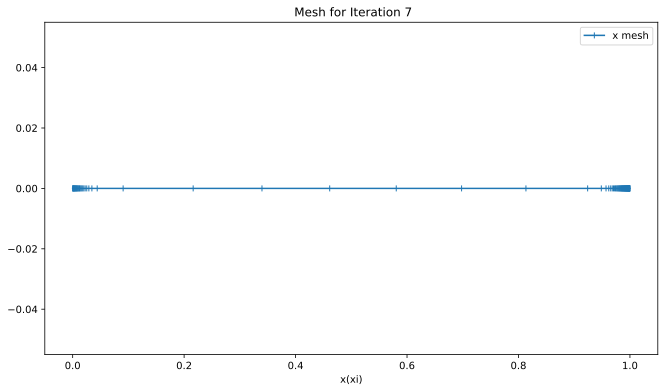



  0 SNES Function norm 3.963778649787e-07
  1 SNES Function norm 1.982172231416e-07


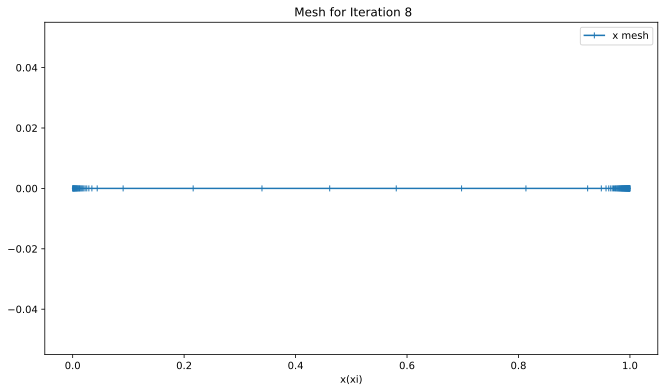



  0 SNES Function norm 1.982172231416e-07
  1 SNES Function norm 9.912626171200e-08


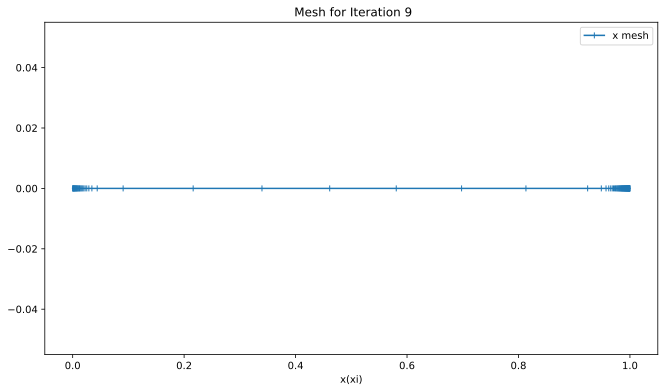



  0 SNES Function norm 9.912626171200e-08
  1 SNES Function norm 4.957649772678e-08


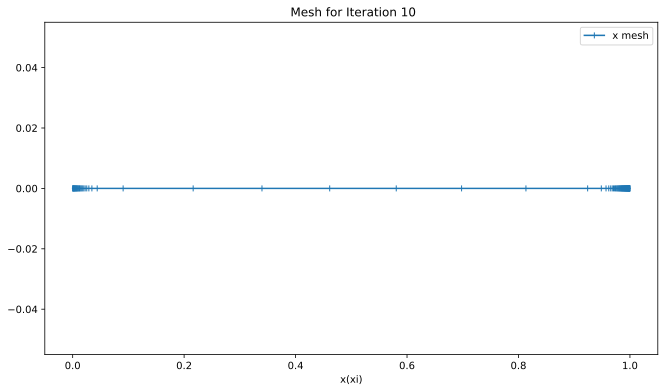



  0 SNES Function norm 4.957649772678e-08
  1 SNES Function norm 2.479129018748e-08


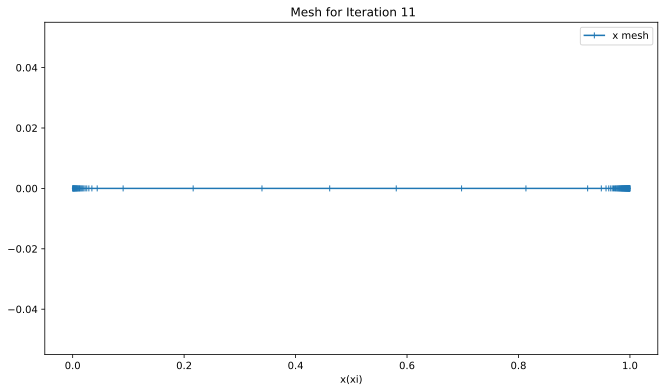



  0 SNES Function norm 2.479129018748e-08
  1 SNES Function norm 1.240359510952e-08


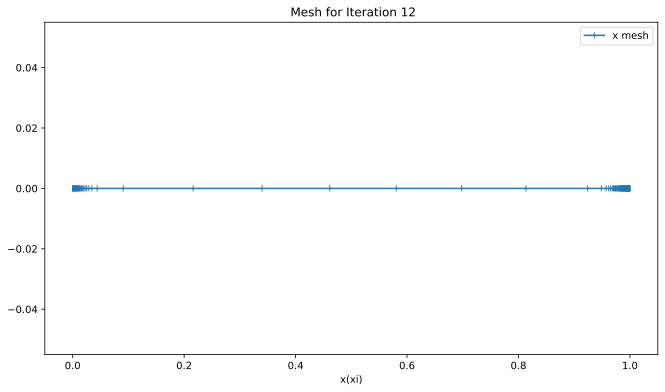



  0 SNES Function norm 1.240359510952e-08
  1 SNES Function norm 6.203952507627e-09


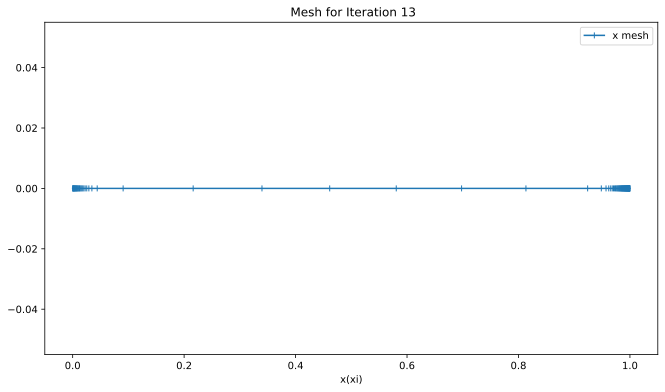



  0 SNES Function norm 6.203952507627e-09
  1 SNES Function norm 3.093159463685e-09


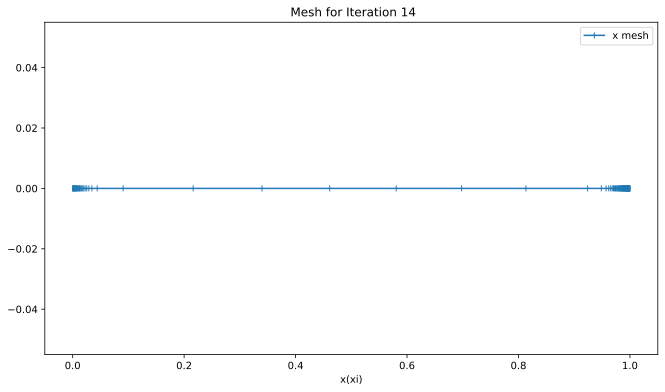



  0 SNES Function norm 3.093159463685e-09
  1 SNES Function norm 1.550354080670e-09


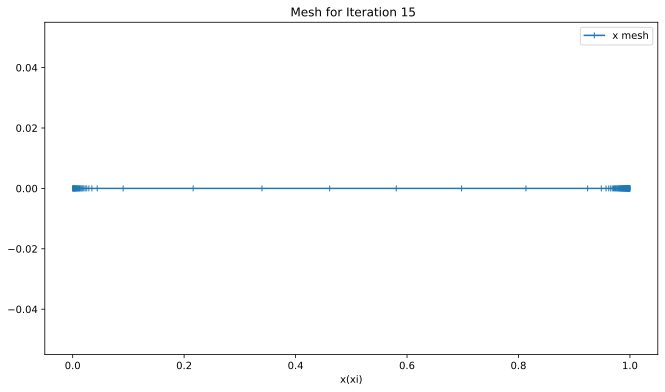



  0 SNES Function norm 1.550354080670e-09
  1 SNES Function norm 7.746699513768e-10


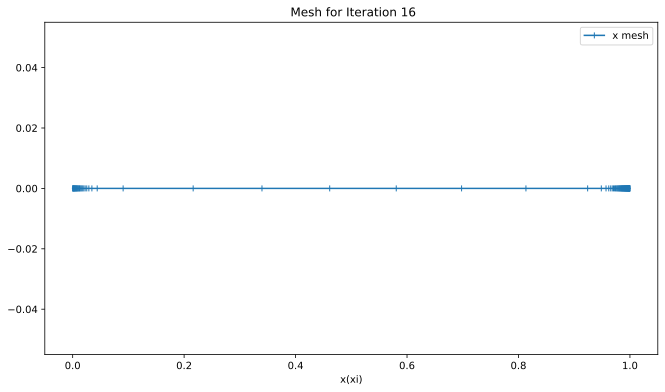



  0 SNES Function norm 7.746699513768e-10
  1 SNES Function norm 3.919265138383e-10


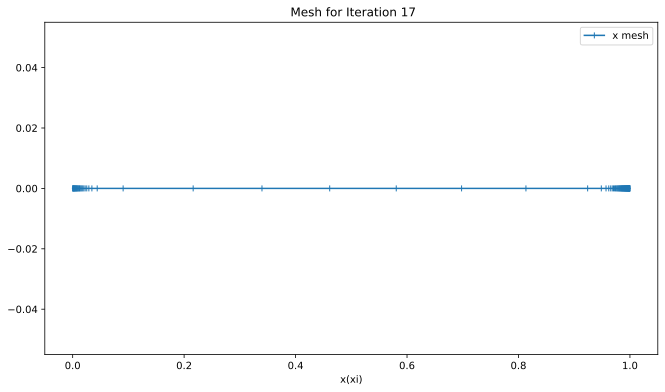



  0 SNES Function norm 3.919265138383e-10
  1 SNES Function norm 2.027962771678e-10


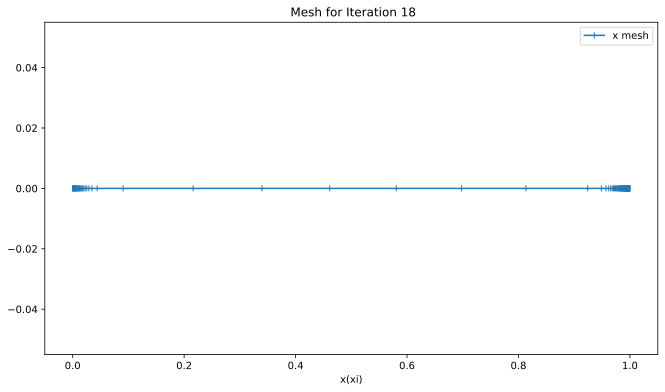



  0 SNES Function norm 2.027962771678e-10
  1 SNES Function norm 1.085459713568e-10


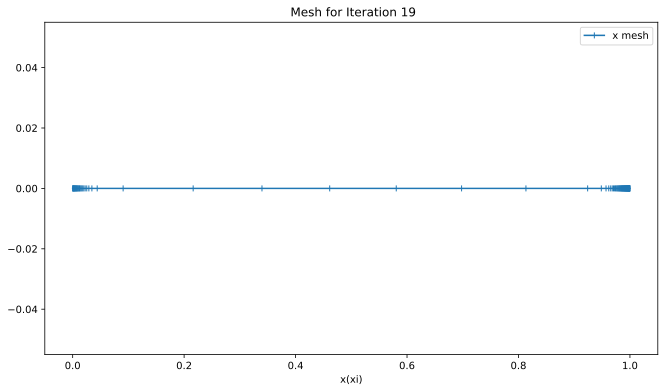



  0 SNES Function norm 1.085459713568e-10
  1 SNES Function norm 6.615712337456e-11


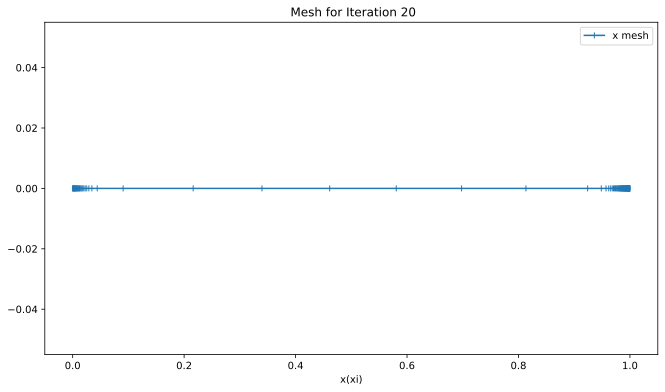



  0 SNES Function norm 6.615712337456e-11
  1 SNES Function norm 4.558436756484e-11


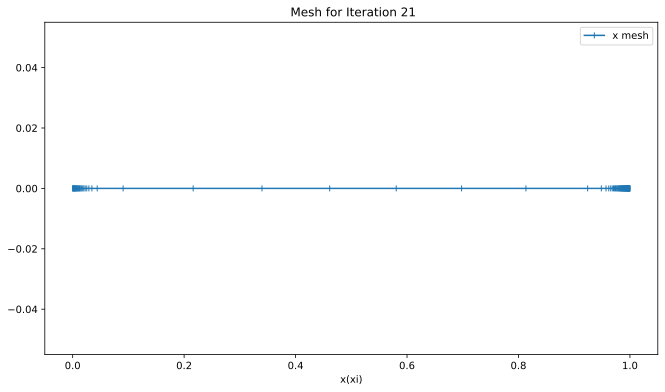



  0 SNES Function norm 4.558436756484e-11
  1 SNES Function norm 4.359400827684e-11


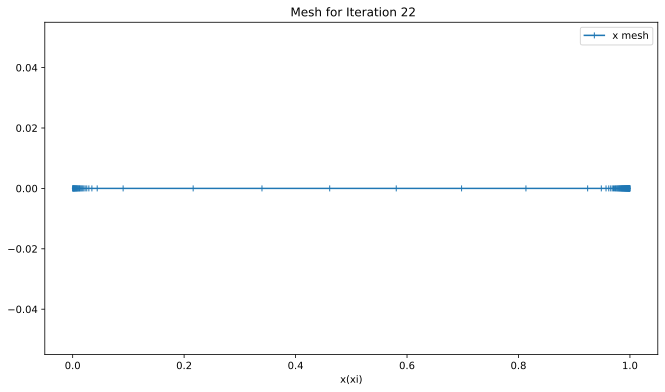



  0 SNES Function norm 4.359400827684e-11
  1 SNES Function norm 3.807579234058e-11


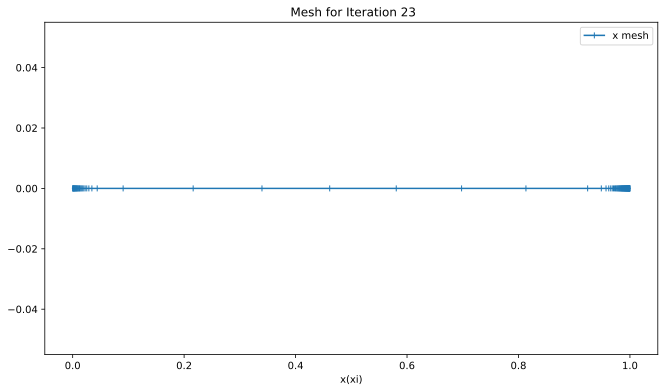



  0 SNES Function norm 3.807579234058e-11
  1 SNES Function norm 3.382475179750e-11


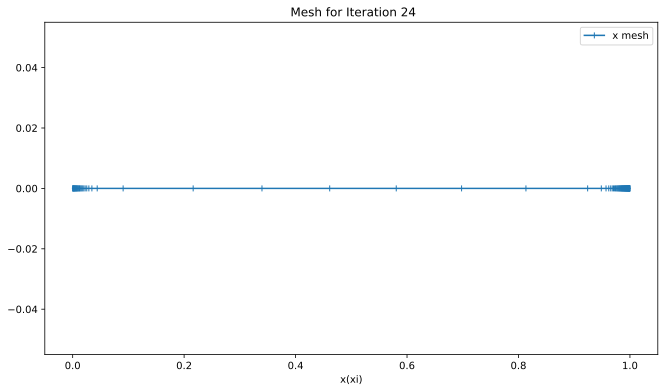

In [ ]:
# NONlinear Mesh Solve

# damping for picard iteration:
w = 1
# MP Iteration count
MP_iter = 25
# Set initial guess
x_old.dat.data[perm_xi] = x_xi_array[:]


# OUR MP ITER:

for i in range(MP_iter):

  # MESH SOLVE
  ##############################################

  # set solution and test function
  new_x = Function(V)
  vm = TestFunction(V)

  # jacobian
  Jm = new_x.dx(0) #dx/dxi

  # Update u
  top = (1 - exp(1 - 1/epsilon))*exp(-new_x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((new_x-1)/epsilon)
  bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
  sub = exp(new_x)/(epsilon**2 - 1)
  u = top/bottom - sub


  # COMPUTE M (using mesh solve x)



  # compute the derivatives of our u
  u_pr = u.dx(0)
  u_prpr = u_pr.dx(0)
  x_prpr = Jm.dx(0)
  du_dx = (1/Jm) * u_pr
  du2_dx2 = ( u_prpr -  du_dx * x_prpr ) * (( 1/Jm )**2)

  # compute the Hessian M using computed alpha tilda

  # Compute alpha using alpha tilda
  # alpha_term1 = alpha_hat * sqrt(assemble(u*u * Jm * dx))
  # alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
  # Now compute M
  inside_bit = 1 + (1/alpha) * abs(du2_dx2) # Corrected: use du2_dx2 instead of du2_dx2_lin
  M = inside_bit ** (exp_M)


  # v'
  v_pr_term = (vm).dx(0)

  # the lhs of the eqn
  Fm = (M * Jm * v_pr_term) * dx

  # bc's
  bc0 = DirichletBC(V, Constant(0), 1)
  bc1 = DirichletBC(V, Constant(1), 2)
  bcs = [bc0, bc1]

  # Set initial guess
  new_x.dat.data[:] = x_old.dat.data[:]

  # Solve
  solve( Fm == 0, new_x, bcs = bcs, solver_parameters = newton_params)

  # update our xold (damped picard)
  x_old.interpolate( (1-w) * x_old + w * new_x )


  # PLOT RESULTING MESH
  ################################################

  perm_x = np.argsort(x_old.dat.data[:])
  plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "x mesh")
  plt.title(' Mesh for Iteration ' + str(i))
  plt.xlabel("x(xi)")
  plt.legend()
  plt.show()
  print()
  print()

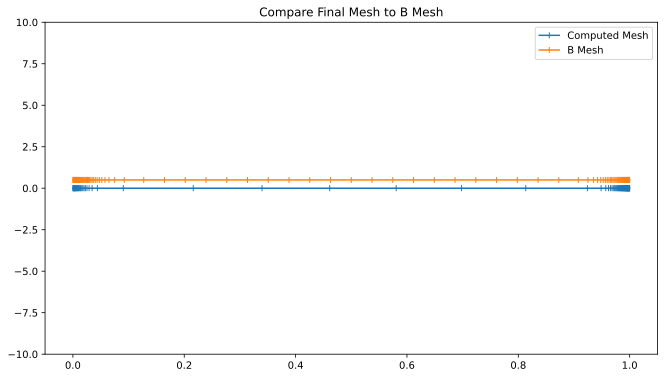

In [ ]:
# Plot result
perm_x = np.argsort(x_old.dat.data[:])
plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Computed Mesh")
plt.plot(x_b, [1/2 for i in range(len(x_b))], marker = "|", label = "B Mesh")
plt.title('Compare Final Mesh to B Mesh')
plt.ylim(-10, 10)
plt.legend()
plt.show()

# Compare the Results

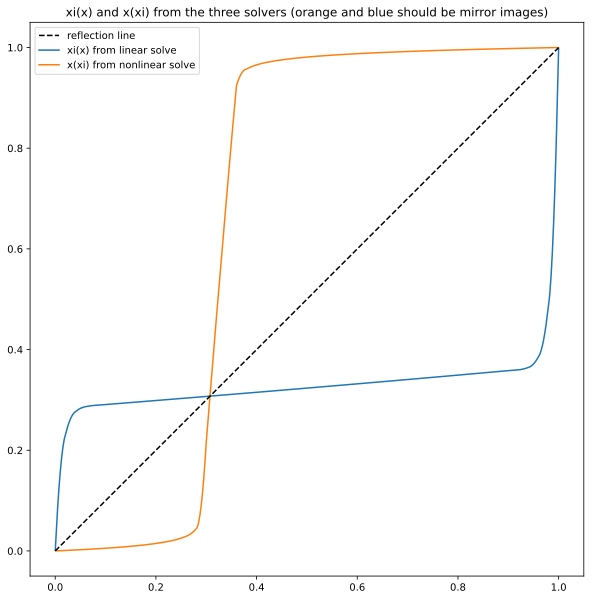

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (10, 10))

#dashed reflection line
plt.plot(np.linspace(0, 1, len(x_old.dat.data[:])), np.linspace(0, 1, len(x_old.dat.data[:])), linestyle = "--", color = "black", label = "reflection line")

# xi(x)
plot(new_xi, axes = axes, label = "xi(x) from linear solve")

# x(xi)
plot(x_old, axes = axes, label = "x(xi) from nonlinear solve")


axes.set_title("xi(x) and x(xi) from the three solvers (orange and blue should be mirror images)")
axes.set_aspect("equal")
plt.legend()
plt.show()
print()
print()

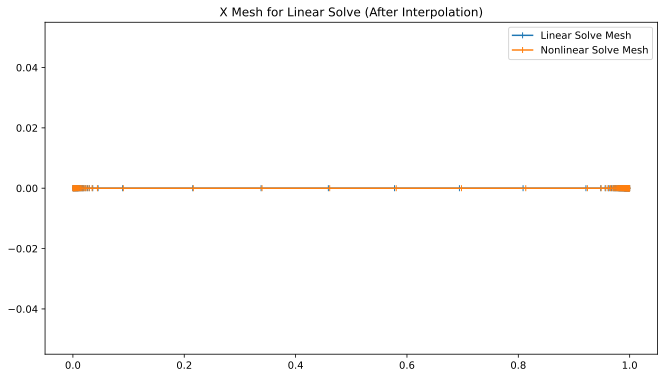

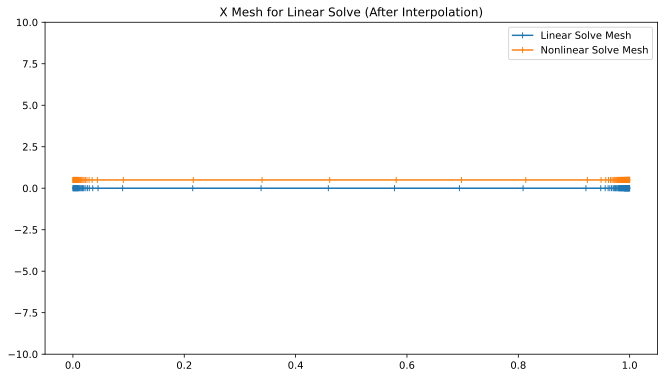

In [ ]:
# Compare the x(xi) meshes

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x_old.dat.data[perm_x], [0 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Nonlinear Solve Mesh")
plt.title('X Mesh for Linear Solve (After Interpolation)')
plt.legend()
plt.show()
print()
print()

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x_old.dat.data[perm_x], [1/2 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Nonlinear Solve Mesh")
plt.title('X Mesh for Linear Solve (After Interpolation)')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()


# Now a Physical Solve - IN CG4 Now

  0 SNES Function norm 4.186513252254e-01
  1 SNES Function norm 3.359535272868e-15




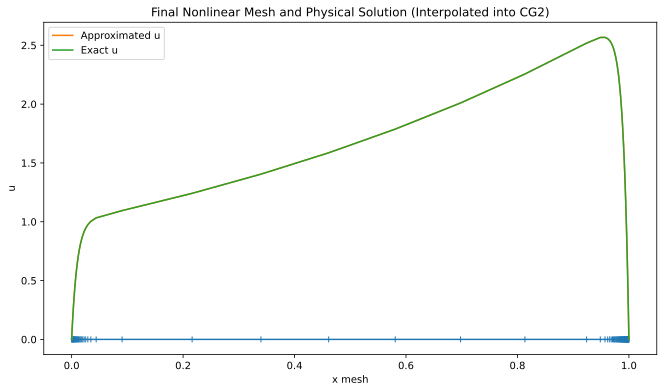

In [ ]:
# PHYSICAL SOLVE
##############################

# Define a CG4 space
V_high = FunctionSpace(xi_mesh, "CG", 4)

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()


# Compute and plot u_exact
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u_exact = top/bottom - sub


# Plot
permute_x = np.argsort(x_old.dat.data[:])
plt.plot(x_old.dat.data[permute_x], np.zeros_like(x_old.dat.data[permute_x]), marker = "|")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u).dat.data[permute_x], label = "Approximated u")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()

## Save x, u, alpha_tilda here for MP Iteration Guesses

In [ ]:
x_guess = Function(V)
x_guess.dat.data[:] = x_old.dat.data[:]

u_guess = Function(V_high)
u_guess.dat.data[:] = u.dat.data[:]

alpha_tilda_guess = alpha_tilda

## Errors

In [ ]:
# ERROR NORMS
###################################


# # Compute L^2 and H^1 errors

# Jacobian of x
Jx = x_old.dx(0)


# L^2 error
error_val = (u - u_exact)
L2_error = norm(error_val * (sqrt(abs(Jx))))
print("L2 error is", L2_error)
print()




# H1 error
# (\epsilon^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
u_approx_pr = (1/Jx) * u.dx(0)
u_exact_pr = (1/Jx) * u_exact.dx(0)
u_pr_error = (u_approx_pr - u_exact_pr)
L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
H1_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
print("H1 error is", H1_error)



# L2 of u
L2_u = norm(u * (sqrt(abs(Jx))))
print()
print("L2 u is", L2_u)

L2 error is 0.0001597100906760019

H1 error is 0.00032314012844884485

L2 u is 1.7523033538210846


## Now a Hessian Recovery Solve to Smooth M

  0 SNES Function norm 1.703728231099e+00
  1 SNES Function norm 2.580761282116e-15



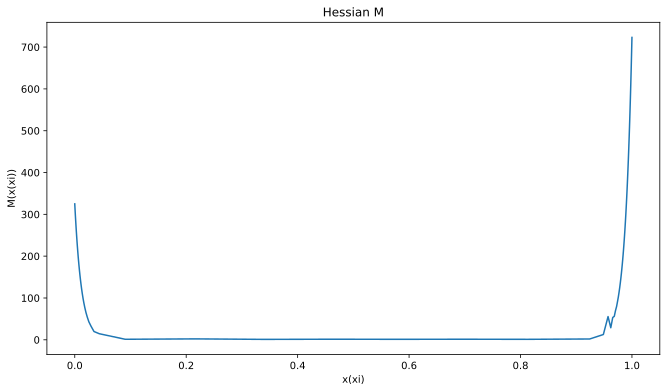

In [ ]:
# Setup
p = Constant(2)
q = Constant(2)
m = Constant(0)
alpha_hat = Constant(1)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M / 2
RHS = float(2.0)

# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}


# Define test and trial function
M_test = TestFunction(V)
M = Function(V)


# x_old jacobian
jacobx = x_old.dx(0) #dx/dxi
# compute the derivatives of our u
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
# compute the Hessian M using computed alpha tilda
# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Now compute M
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)


# The weak form
a_M = inner(M*jacobx, M_test)*dx
L_M = inner(M_h*jacobx, M_test)*dx
# a_M = inner(M, M_test)*dx
# L_M = inner(M_h, M_test)*dx

# Solve
M.interpolate(M_h)
solve((a_M - L_M) == 0, M, solver_parameters = lu_params)

# Print result
print()
plt.plot(x_old.dat.data[perm_old], M.dat.data[perm_old])
plt.xlabel("x(xi)")
plt.ylabel("M(x(xi))")
plt.title("Hessian M")
plt.show()
print()
print()

## Now a Mesh Solve

In [ ]:
# MESH SOLVE
#############################################




# SETUP


mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}




# # HESSIAN


# # x_old jacobian
# jacobx = x_old.dx(0) #dx/dxi
# # compute the derivatives of our u
# u_pr_lin = u.dx(0)
# u_prpr_lin = u_pr_lin.dx(0)
# x_prpr_lin = jacobx.dx(0)
# du_dx_lin = (1/jacobx) * u_pr_lin
# du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
# # compute the Hessian M using computed alpha tilda
# # Compute alpha using alpha tilda
# alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
# alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# # Now compute M
# inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
# M_lin = inside_bit_lin ** (exp_M)



# MESH PROBLEM

print('norm(xold) = ', norm(x_old))
print()


# set solution and test function
new_x = Function(V).interpolate(x_old)
vm = TestFunction(V)

# jacobian
Jm = new_x.dx(0) #dx/dxi

# v'
v_pr_term = (vm).dx(0)

# the lhs of the eqn
am = (M * Jm * v_pr_term) * dx


# bc's
bc0 = DirichletBC(V, Constant(0), 1)
bc1 = DirichletBC(V, Constant(1), 2)
bcs = [bc0, bc1]


# Solve
solve( am == 0, new_x, bcs = bcs, solver_parameters = mesh_params)


print()
print('norm(x_new)) = ', norm(new_x))
print()
print()

print('Starting Mesh:')
print(x_old.dat.data[:])
print()
print('Final Mesh:')
print(new_x.dat.data[:])
print()


# Save this mesh for later comparison
x_noMP = Function(V)
x_noMP.dat.data[:] = new_x.dat.data[:]

norm(xold) =  0.8044565971889802

  0 SNES Function norm 2.524359658399e+01
  1 SNES Function norm 7.111559575981e-11

norm(x_new)) =  0.8052190848346148


Starting Mesh:
[4.42017975e-04 0.00000000e+00 9.00229447e-04 1.37586727e-03
 1.87030698e-03 2.38509789e-03 2.92198397e-03 3.48294931e-03
 4.07025058e-03 4.68648582e-03 5.33464686e-03 6.01822761e-03
 6.74131251e-03 7.50875570e-03 8.32633843e-03 9.20108400e-03
 1.01415578e-02 1.11584651e-02 1.22652748e-02 1.34794763e-02
 1.48240367e-02 1.63304371e-02 1.80426914e-02 2.00263488e-02
 2.23827533e-02 2.52863124e-02 2.90630425e-02 3.44973685e-02
 4.40440500e-02 9.05652866e-02 2.16239372e-01 3.39710107e-01
 4.61232100e-01 5.80669506e-01 6.97891525e-01 8.13375335e-01
 9.24107836e-01 9.48656525e-01 9.57107591e-01 9.61999079e-01
 9.65517671e-01 9.68261757e-01 9.70512783e-01 9.72420275e-01
 9.74075599e-01 9.75537423e-01 9.76846379e-01 9.78031320e-01
 9.79113766e-01 9.80109992e-01 9.81032745e-01 9.81892096e-01
 9.82696210e-01 9.83451745e-01 9.841

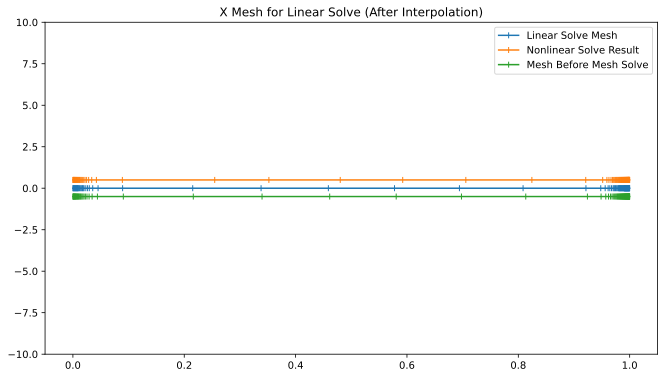

In [ ]:
# Compare to the Linear Solve Mesh

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(new_x.dat.data[perm_x], [1/2 for i in range(len(new_x.dat.data[:]))], marker = "|", label = "Nonlinear Solve Result")
plt.plot(x_old.dat.data[perm_x], [-1/2 for i in range(len(x_old.dat.data[:]))], marker = "|", label = "Mesh Before Mesh Solve")
plt.title('X Mesh for Linear Solve (After Interpolation)')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

## Now a Physical Solve

norm(u) before =  1.4581607718124017

  0 SNES Function norm 4.167373469393e-01
  1 SNES Function norm 3.231695753683e-15


norm(u) after =  1.4478639836121032



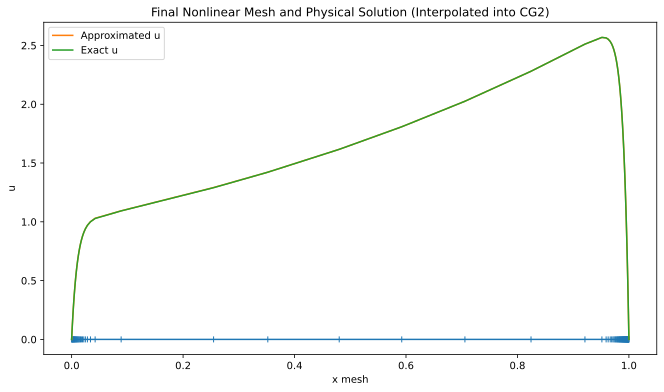

In [ ]:
# PHYSICAL SOLVE
##############################

print('norm(u) before = ', norm(u))
print()


# Update x_old as new_x
x_old.dat.data[:] = new_x.dat.data[:]

# Test and Trial Functions
u = TrialFunction(V_high)
v = TestFunction(V_high)

# Jacobian of x
Jx = x_old.dx(0) #dx/dxi


# Set the bilinear and linear forms of the weak form
u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jx * dx # transform dxi to dx
L = ( exp(x_old) ) * v * Jx * dx #transform dxi to dx


# Set the BC's
bcs = [DirichletBC(V_high, Constant(0), 1), DirichletBC(V_high, Constant(0), 2)]


# Solve
u = Function(V_high)
solve( a==L, u, bcs = bcs, solver_parameters = lu_params)

print()
print()


# Print norm
print('norm(u) after = ', norm(u))
print()


# Compute and plot u_exact
top = (1 - exp(1 - 1/epsilon))*exp(-x_old/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x_old-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x_old)/(epsilon**2 - 1)
u_exact = top/bottom - sub


# Plot
permute_x = np.argsort(x_old.dat.data[:])
plt.plot(x_old.dat.data[permute_x], np.zeros_like(x_old.dat.data[permute_x]), marker = "|")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u).dat.data[permute_x], label = "Approximated u")
plt.plot(x_old.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("Final Nonlinear Mesh and Physical Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()
print()
print()
print()




## Now a Alpha Solve

In [ ]:
# ALPHA TILDA PROBLEM

newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'mat_type': 'nest'
}



# Define test function
a_test = TestFunction(V_alpha)
alpha_tilda = Function(V_alpha).interpolate(alpha_tilda_guess)

print()
print("alpha_tilda before = ", float(alpha_tilda))
print()

# second derivtaive of u
Jm = x_old.dx(0)
u_pr = u.dx(0)
du_dx = (1/Jm) * u_pr
u_prpr = (u_pr).dx(0)
x_prpr = Jm.dx(0)
du2_dx2 = ( u_prpr -  du_dx * x_prpr) * (( 1/Jm )**2)

# Our problem
inside_bit = 1 + (1/alpha_tilda) * abs(du2_dx2)
rho = inside_bit ** (exp_rho)
a_rho = inner(rho * Jm, a_test) * dx
L_rho = inner(RHS, a_test) * dx

# Solve
solve( (a_rho - L_rho) == 0, alpha_tilda, solver_parameters = newton_params)

# Print result
print()
print("alpha_tilda after = ", float(alpha_tilda))


alpha_tilda before =  7.250865204319422

  0 SNES Function norm 1.428347559897e-02
  1 SNES Function norm 1.301716972206e-04
  2 SNES Function norm 1.656864172583e-06
  3 SNES Function norm 2.077852110857e-08
  4 SNES Function norm 2.605311591464e-10
  5 SNES Function norm 3.266522469181e-12

alpha_tilda after =  7.043420808577267


#  MP-Iteration Via FieldSplit

## Solvers

In [ ]:
from firedrake.preconditioners.base import SNESBase
from firedrake.petsc import PETSc
from firedrake.dmhooks import get_appctx, get_function_space
from firedrake.function import Function



__all__ = ("FieldsplitSNES",)


class FieldsplitSNES(SNESBase):
    prefix = "fieldsplit_"

    # TODO:
    #   - Allow setting field grouping/ordering like fieldsplit

    @PETSc.Log.EventDecorator()
    def initialize(self, snes):
        from firedrake.variational_solver import NonlinearVariationalSolver  # ImportError if we do this at file level
        ctx = get_appctx(snes.dm)
        W = get_function_space(snes.dm)
        self.sol = ctx._problem.u_restrict

        # buffer to save solution to outer problem during solve
        self.sol_outer = Function(self.sol.function_space())

        # buffers for shuffling solutions during solve
        self.sol_current = Function(self.sol.function_space())
        self.sol_new = Function(self.sol.function_space())

        # options for setting up the fieldsplit
        snes_prefix = snes.getOptionsPrefix() + 'snes_' + self.prefix
        # options for each field
        sub_prefix = snes.getOptionsPrefix() + self.prefix

        snes_options = PETSc.Options(snes_prefix)
        self.fieldsplit_type = snes_options.getString('type', 'additive')
        if self.fieldsplit_type not in ('additive', 'multiplicative'):
            raise ValueError(
                'FieldsplitSNES option snes_fieldsplit_type must be'
                ' "additive" or "multiplicative"')

        split_ctxs = ctx.split([(i,) for i in range(len(W))])

        self.solvers = tuple(
            NonlinearVariationalSolver(
                ctx._problem, appctx=ctx.appctx,
                options_prefix=sub_prefix+str(i))
            for i, ctx in enumerate(split_ctxs)
        )

    def update(self, snes):
        pass

    @PETSc.Log.EventDecorator()
    def step(self, snes, x, f, y):
        # store current value of outer solution
        self.sol_outer.assign(self.sol)

        # the full form in ctx now has the most up to date solution
        with self.sol_current.dat.vec_wo as vec:
            x.copy(vec)
        self.sol.assign(self.sol_current)

        # The current snes solution x is held in sol_current, and we
        # will place the new solution in sol_new.
        # The solvers evaluate forms containing sol, so for each
        # splitting type sol needs to hold:
        #   - additive: all fields need to hold sol_current values
        #   - multiplicative: fields need to hold sol_current before
        #       they are are solved for, and keep the updated sol_new
        #       values afterwards.


        solver_count = 0
        solver_list = ["M update", "mesh solve", "physical solve", "mesh update", "alpha solve"]
        print()
        print()
        print()
        print()
        print("MP ITERATION")
        print('_'*50)
        print()





        for solver, u, ucurr, unew in zip(self.solvers,
                                          self.sol.subfunctions,
                                          self.sol_current.subfunctions,
                                          self.sol_new.subfunctions):



            print(solver_list[solver_count])
            print('_'*50)
            print()


            if solver_count == 0:

              x_perm = np.argsort(self.sol.subfunctions[1].dat.data[:])

              plt.plot(self.sol.subfunctions[1].dat.data[x_perm], self.sol.subfunctions[0].dat.data[x_perm])
              plt.title("M before solve")
              plt.show()
              print()
              print()


            print('norm(u) before solve = ', norm(u))
            print()


            # print('The solver problem is',  solver._problem.F)
            # print()

            # print('The solver is solving for', solver._problem.u)
            # print()



            solver.solve()
            unew.assign(u)
            if self.fieldsplit_type == 'additive':
                u.assign(ucurr)



            print()
            print('norm(u) after solve = ', norm(u))
            print()


            if solver_count == 0:

              plt.plot(self.sol.subfunctions[1].dat.data[x_perm], self.sol.subfunctions[0].dat.data[x_perm])
              plt.title("M after solve")
              plt.show()
              print()
              print()


            solver_count += 1


        with self.sol_new.dat.vec_ro as vec:
            vec.copy(y)
            y.aypx(-1, x)

        # restore outer solution
        self.sol.assign(self.sol_outer)

## Setup

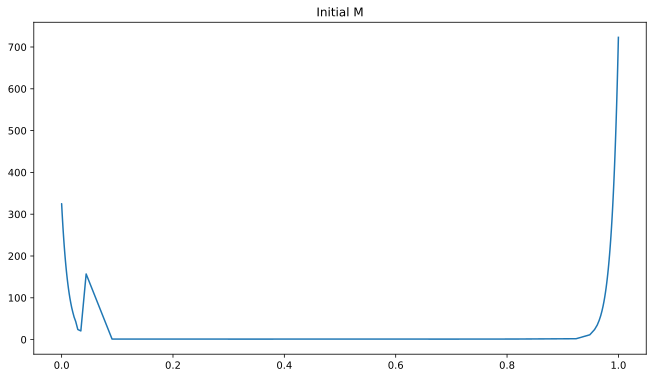

In [ ]:
# SET UP FOR MP ITERATION
##############################################


# Set our parameters for the hessian mesh density
# d = 1
p = Constant(2)
q = Constant(2)
m = Constant(0)
alpha_hat = Constant(1)
exp_M = (2*q) / (1 + q*(2-m))
exp_rho = exp_M / 2
RHS = float(2.0)


# OUr function space and solutions
W = V * V * V_high * V * V_alpha
mxuxa = Function(W)
myvyb = TestFunction(W)


# An initial guess for M

jacobx = x_guess.dx(0)
u_pr_lin = u_guess.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda_guess) , alpha_term1, alpha_tilda_guess)
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_guess = inside_bit_lin ** (exp_M)



# set our initial guesses
mxuxa.sub(0).interpolate(M_guess)
mxuxa.sub(1).interpolate(x_guess)
mxuxa.sub(2).interpolate(u_guess)
mxuxa.sub(3).interpolate(x_guess)
mxuxa.sub(4).interpolate(alpha_tilda_guess)


plt.plot(mxuxa.sub(1).dat.data[:], mxuxa.sub(0).dat.data[:])
plt.title("Initial M")
plt.show()
print()
print()



## Test





MP ITERATION
__________________________________________________

M update
__________________________________________________



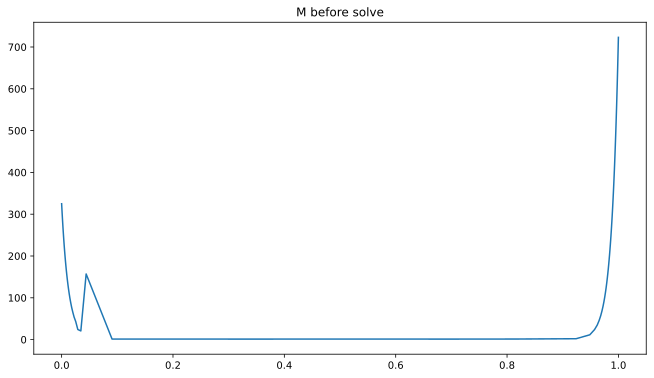



norm(u) before solve =  349.17218747406

  0 SNES Function norm 1.703728231099e+00
  1 SNES Function norm 2.000115090887e-15

norm(u) after solve =  349.0051517219993



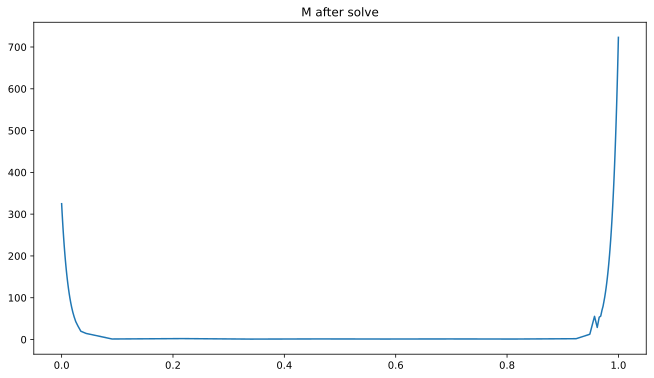



mesh solve
__________________________________________________

norm(u) before solve =  0.8044565971889802

  0 SNES Function norm 2.524359658399e+01
  1 SNES Function norm 5.850037033451e-11

norm(u) after solve =  0.8052190848346147

physical solve
__________________________________________________

norm(u) before solve =  1.4581607718124017

  0 SNES Function norm 6.142995425644e-03
  1 SNES Function norm 1.405377831940e-02

norm(u) after solve =  1.4479899900171571

mesh update
__________________________________________________

norm(u) before solve =  0.8044565971889802

  0 SNES Function norm 3.828102328608e-04
  1 SNES Function norm 1.791470926219e-18

norm(u) after solve =  0.8052190848346147

alpha solve
__________________________________________________

norm(u) before solve =  7.250865204319422

  0 SNES Function norm 2.050909532661e-02
  1 SNES Function norm 2.201571854069e-02
  2 SNES Function norm 2.364013311610e-02
  3 SNES Function norm 2.539266656401e-02
  4 SNES Func

In [ ]:
# MP ITERATION
################################################


# Retrieve our functions
M, x,u, x_old, alpha_tilda = split(mxuxa)
M_test, y,v, y_old, a_test = split(myvyb)



# x_old jacobian
jacobx = x_old.dx(0) #dx/dxi

# compute the derivatives of our u
u_pr_lin = u.dx(0)
u_prpr_lin = u_pr_lin.dx(0)
x_prpr_lin = jacobx.dx(0)
du_dx_lin = (1/jacobx) * u_pr_lin
du2_dx2_lin = ( u_prpr_lin -  du_dx_lin * x_prpr_lin) * (( 1/jacobx )**2)


# compute the Hessian M using computed alpha tilda

# Compute alpha using alpha tilda
alpha_term1 = alpha_hat * sqrt(assemble(u*u * jacobx * dx))
alpha = conditional( gt(alpha_term1, alpha_tilda) , alpha_term1, alpha_tilda)
# Compute Mh
inside_bit_lin = 1 + (1/alpha) * abs(du2_dx2_lin)
M_h = inside_bit_lin ** (exp_M)
# Weak form for projected M
a_M = inner(M*jacobx, M_test) * dx
L_M = inner(M_h*jacobx, M_test) * dx
# a_M = inner(M, M_test) * dx
# L_M = inner(M_h, M_test) * dx


# jacobian based on current x
Jm = x.dx(0) #dx/dxi


# Physical PDE
u_deriv = (1/Jm) * u.dx(0) # transform to du/dx
v_deriv = (1/Jm) * v.dx(0) # transform to dv/dx
a_p = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u, v)) * Jm * dx # transform dxi to dx
L_p = ( exp(x) ) * v * Jm * dx #transform dxi to dx


# y' where y is test for x
y_pr_term = y.dx(0)


# Now our alpha_tilda equation
u_pr = u.dx(0)
du_dx = (1/Jm) * u_pr # transform to du/dx
u_prpr = (u_pr).dx(0)
x_prpr = Jm.dx(0)
du2_dx2 = ( u_prpr -  du_dx * x_prpr) * (( 1/Jm )**2)

inside_bit = 1 + (1/alpha_tilda) * abs(du2_dx2)
rho = inside_bit ** (exp_rho)
a_rho = inner(rho * Jm, a_test) * dx
L_rho = inner(RHS, a_test) * dx






# Total form
F = (a_M - L_M) + (M * Jm * y_pr_term)*dx + (a_p - L_p) + (x-x_old)*y_old*dx + (a_rho - L_rho)




# bc's
bcx0 = DirichletBC(W.sub(1), Constant(0), 1)
bcx1 = DirichletBC(W.sub(1), Constant(1), 2)
bcu0 = DirichletBC(W.sub(2), Constant(0), 1)
bcu1 = DirichletBC(W.sub(2), Constant(0), 2)
bcs = [bcx0, bcx1, bcu0, bcu1]



# solver parameters

lu_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    # 'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}




newton_params = {
        'snes_type': 'newtonls',
        'snes_monitor': None,
        'ksp_type': 'preonly',
        'mat_type': 'nest'
}


GS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.GaussSeidelSNES',
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_gs_0': lu_params,
    'npc_gs_1': lu_params,
    'npc_gs_2': lu_params,
    'npc_gs_3': newton_params,
    'snes_max_it': 20,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}



FS_params = {
    'mat_type': 'nest',
    'snes_type': 'nrichardson',
    'snes_monitor': None,
    'npc_snes_type': 'python',
    'npc_snes_python_type': __name__+'.FieldsplitSNES',
    'npc_snes_fieldsplit_type': "multiplicative",
    'snes_linesearch_type': 'basic',
    'snes_linesearch_monitor': None,
    'snes_linesearch_damping': 0.5,
    'npc_fieldsplit_0': lu_params,
    'npc_fieldsplit_1': mesh_params,
    'npc_fieldsplit_2': lu_params,
    'npc_fieldsplit_3': lu_params,
    'npc_fieldsplit_4': newton_params,
    'snes_max_it': 20,
    'snes_rtol': 1e-12,
    'snes_atol': 1e-50,
    'snes_stol': 1e-12,
}




# solve the problem

try:
  NLVP = NonlinearVariationalProblem(F, mxuxa, bcs=bcs)
  NLVS = NonlinearVariationalSolver(NLVP, solver_parameters=FS_params)
  NLVS.solve()
except Exception as e:
  print()
  print()
  print('Solver failed because of the following message:')
  print(e)
  print()

# Save our progress
M, x, u, x_old, alpha_tilda = mxuxa.subfunctions

# Compare Meshes

In [ ]:
# Print norm of difference

print('Norm of mesh differences', norm(x-x_noMP))
print()
print()
print()


# Print each mesh point

print("COMPARING EACH MESH POINT")
print("_"*100)
print()

for i in range(N+1):

  print("Single Mesh Solve:", x_noMP.dat.data[i], end = "    ")
  print("MP Mesh Solve:", x.dat.data[i])
  print()

Norm of mesh differences 2.428530403930602e-16



COMPARING EACH MESH POINT
____________________________________________________________________________________________________

Single Mesh Solve: 0.0004308115376283199    MP Mesh Solve: 0.0004308115376283207

Single Mesh Solve: 0.0    MP Mesh Solve: 0.0

Single Mesh Solve: 0.0008774035567267005    MP Mesh Solve: 0.0008774035567267021

Single Mesh Solve: 0.001340983310389392    MP Mesh Solve: 0.0013409833103893943

Single Mesh Solve: 0.0018228847636759494    MP Mesh Solve: 0.0018228847636759526

Single Mesh Solve: 0.002324625927591803    MP Mesh Solve: 0.0023246259275918075

Single Mesh Solve: 0.0028478972489678705    MP Mesh Solve: 0.0028478972489678757

Single Mesh Solve: 0.0033946436643851373    MP Mesh Solve: 0.003394643664385143

Single Mesh Solve: 0.003967051504281824    MP Mesh Solve: 0.003967051504281831

Single Mesh Solve: 0.00456766894600346    MP Mesh Solve: 0.004567668946003468

Single Mesh Solve: 0.0051993928524131415    MP

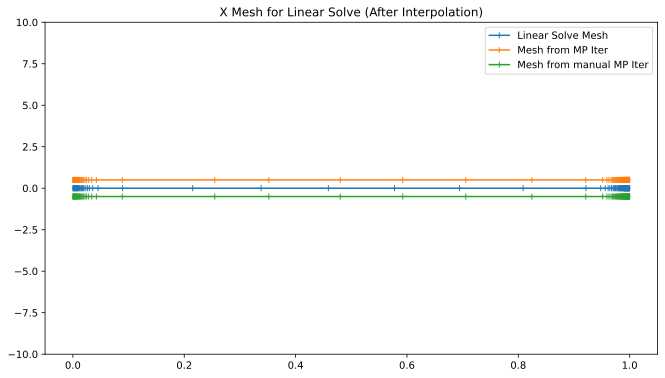

In [ ]:
# Compare to the Linear Solve Mesh

plt.plot(x_xi_array, [0 for i in range(len(x_xi_array))], marker = "|", label = "Linear Solve Mesh")
plt.plot(x.dat.data[perm_x], [1/2 for i in range(len(x.dat.data[:]))], marker = "|", label = "Mesh from MP Iter")
plt.plot(x_noMP.dat.data[perm_x], [-1/2 for i in range(len(x_noMP.dat.data[:]))], marker = "|", label = "Mesh from manual MP Iter")
plt.title('X Mesh for Linear Solve (After Interpolation)')
plt.ylim(-10, 10)
plt.legend()
plt.show()
print()
print()

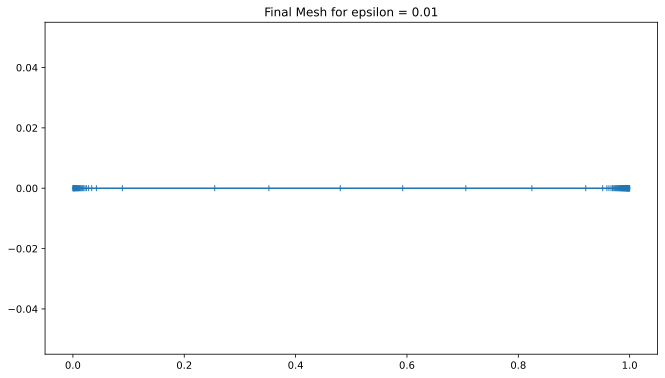

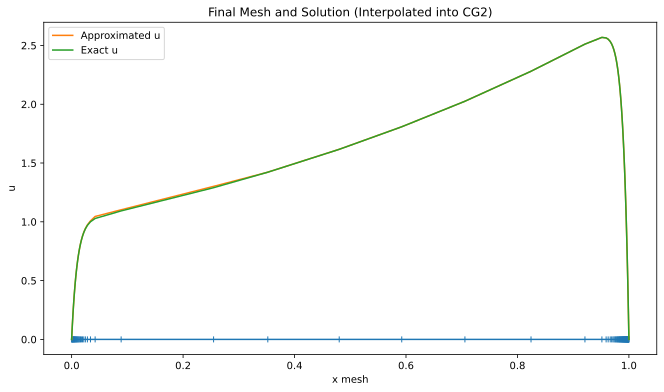



final alpha_tilda =  -1.5318801334894432


In [ ]:
# Plot the results

permute_x = np.argsort(x.dat.data[:])

# exact u
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_exact = top/bottom - sub


# Just the mesh
# print final mesh
plt.plot(x.dat.data[permute_x], [0 for i in range(len(x.dat.data[permute_x]))], marker = "|")
plt.title("Final Mesh for epsilon = " + str(float(epsilon)))
plt.show()
print()
print()





# Solutions and Meshes

print()
plt.plot(x.dat.data[permute_x], np.zeros_like(x.dat.data[permute_x]), marker = "|")
plt.plot(x.dat.data[permute_x], Function(V).interpolate(u).dat.data[permute_x], label = "Approximated u")
plt.plot(x.dat.data[permute_x], Function(V).interpolate(u_exact).dat.data[permute_x], label = "Exact u")
plt.title("Final Mesh and Solution (Interpolated into CG2)")
plt.xlabel("x mesh")
plt.ylabel("u")
plt.legend()
plt.show()

print()
print()

print("final alpha_tilda = ", alpha_tilda.dat.data[:][0])